In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopy
from geopy import distance
from geopy.distance import vincenty
# from tqdm import tqdm
# tqdm.pandas()
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
import numpy as np

import eli5
from eli5.sklearn import PermutationImportance
# from skopt.space import Real
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [44]:
train = pd.read_csv('listings.csv.gz', compression='gzip')
price_df = pd.read_csv('listings.csv')


In [57]:
train.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,10291,https://www.airbnb.com/rooms/10291,20190306190816,2019-03-06,Spacious Cottage in Mid-City!,NaN,"Spacious house located in Mid-City, New Orlean...","Spacious house located in Mid-City, New Orlean...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/99566384/f...,NaN,31004,https://www.airbnb.com/users/show/31004,Jill,2009-08-11,"New Orleans, Louisiana, United States",I'm from New Orleans and work in the insurance...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/31004/profile...,https://a0.muscache.com/im/users/31004/profile...,Navarre,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"New Orleans, LA, United States",Navarre,Navarre,NaN,New Orleans,LA,70124,New Orleans,"New Orleans, LA",US,United States,29.98666,-90.10928,t,Cottage,Entire home/apt,4,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$300.00,NaN,NaN,$0.00,$100.00,4,$0.00,2,365,2,2,365,365,2.0,365.0,4 weeks ago,t,13,32,60,331,2019-03-06,96,14,2011-03-07,2019-02-17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,17STR-04686,"{""Louisiana State"","" New Orleans"","" LA""}",f,f,moderate,t,f,1,1,0,0,0.99
1,19091,https://www.airbnb.com/rooms/19091,20190306190816,2019-03-06,Fully Furnished Cozy Apartment,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,SEE SPECIAL REDUCED SUMMER PRICING! This apa...,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,none,"NorthWest Carrollton, where this apartment is ...",NaN,If you are going to use the trolley or bus sys...,Guests who stay for a week or longer will have...,The host is available for help with the apartm...,No smoking! No drugs. No pets. On street par...,NaN,NaN,https://a0.muscache.com/im/pictures/957168/75e...,NaN,72880,https://www.airbnb.com/users/show/72880,John,2010-01-23,"New Orleans, Louisiana, United States",I recently (2018) retired as the Director of B...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/72880/profile...,https://a0.muscache.com/im/users/72880/profile...,Riverbend,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"New Orleans, LA, United States",Uptown/Carrollton District,Leonidas,NaN,New Orleans,LA,70118,New Orleans,"New Orleans, LA",US,United States,29.96257,-90.11877,t,Apartment,Entire home/apt,3,1.0,

In [60]:

lon = -90.0680352
lat = 29.9585246
train['distance_center'] = train.apply(lambda x: vincenty((x['latitude'], x['longitude']), (lat, lon)).miles, axis = 1)




In [61]:
train['distance_center'].describe()

count    6632.000000
mean        1.946200
std         1.576078
min         0.029375
25%         0.913820
50%         1.662018
75%         2.597029
max        24.292619
Name: distance_center, dtype: float64

In [62]:
train['distance_center'].min()

0.029374828173485655

In [63]:
train = train.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])


In [64]:
df = train.groupby(['neighbourhood_cleansed']).mean()
price_grouped = price_df.groupby(['neighbourhood']).mean()
price = price_grouped['price']

In [65]:
df['price']=price

In [66]:
df = df.replace([np.inf, -np.inf], np.nan)
df.head()

,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,distance_center
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Algiers Point,NaN,7.606557,7.606557,4.262295,1.426230,1.934426,2.573770,856.666667,140.786885,281.730769,79.534483,2.540984,2.147541,612.426230,2.016393,2.409836,612.426230,612.426230,2.178689,612.426230,6.540984,17.836066,35.147541,173.114754,50.491803,23.426230,97.754386,9.877193,9.842105,9.982456,9.912281,9.824561,9.859649,2.491803,2.344262,0.147541,0.0,1.148790
Audubon,NaN,5.032787,5.032787,4.770492,1.602459,2.032787,2.704918,250.000000,240.122951,387.247706,95.521739,2.786885,3.745902,610.745902,3.713115,4.040984,610.745902,610.745902,3.770492,610.745902,9.524590,22.803279,41.663934,155.598361,37.852459,17.918033,97.214286,9.883929,9.758929,9.982143,9.964286,9.919643,9.732143,2.254098,1.836066,0.418033,0.0,3.612738
Bayou St. John,NaN,5.128788,5.128788,4.280303,1.393939,1.787879,2.386364,1493.500000,182.477273,235.096154,75.738739,2.151515,3.159091,666.537879,2.893939,3.681818,637.446970,655.022727,3.228030,637.772727,7.446970,18.204545,36.886364,139.772727,36.833333,14.628788,97.904000,9.928000,9.856000,9.976000,9.984000,9.736000,9.864000,2.621212,2.416667,0.204545,0.0,1.529790
Behrman,NaN,1.166667,1.166667,4.666667,1.375000,2.083333,2.583333,NaN,122.750000,111.111111,73.777778,2.166667,1.916667,541.166667,1.916667,2.083333,541.166667,541.166667,1.975000,541.166667,9.916667,28.333333,52.583333,185.583333,15.166667,10.000000,94.888889,9.666667,9.555556,10.000000,10.000000,9.555556,9.777778,1.166667,1.083333,0.083333,0.0,2.827476
Black Pearl,NaN,14.137931,14.137931,3.655172,1.275862,1.724138,2.103448,NaN,147.862069,208.652174,74.192308,2.206897,4.068966,571.413793,4.034483,4.275862,571.413793,571.413793,4.086207,571.413793,6.862069,17.344828,32.586207,145.551724,45.931034,18.413793,96.923077,9.923077,9.769231,10.000000,9.884615,9.846154,9.730769,3.206897,2.827586,0.379310,0.0,4.092445


In [67]:
price_high = df.loc[(df['price']>=225)]
price_mid = df[(df['price']>150) & (df['price'] <225)]
price_low = df[(df['price']>=0) & (df['price'] <150)]
p_low = price_low.reset_index()
p_mid = price_mid.reset_index()
p_high = price_high.reset_index()

In [68]:
def bar_price(feature, index):
    fig, ax = plt.subplots()
    x_axis = np.arange(len(feature['price']))
    ax.bar(x_axis, feature['price'])
    labels =index['neighbourhood_cleansed']
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels, rotation=50, ha="right")

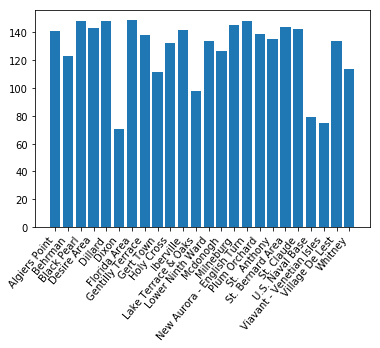

In [69]:
bar_price(price_low, p_low)

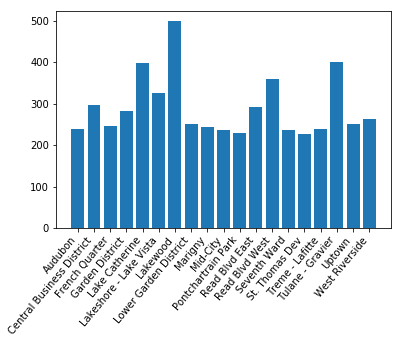

In [70]:
bar_price(price_high, p_high)

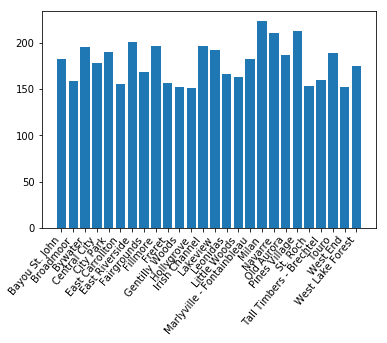

In [71]:
bar_price(price_mid, p_mid)

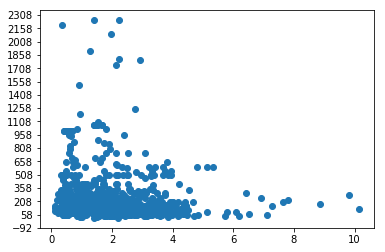

In [72]:

sample = train.sample(1000, random_state=42)
labels = ['0','50','100','150','200','250','300','350','400','450','500']
train['price']=(train['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['cleaning_fee']=(train['cleaning_fee'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['security_deposit']=(train['security_deposit'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
price = sample['price']
dist = sample['distance_center']
fig, ax = plt.subplots()
ax.scatter(dist, price)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 150))

In [73]:
cleanmean=train['cleaning_fee'].dropna().mean()
train['cleaning_fee']=train['cleaning_fee'].fillna(cleanmean)
# train['cleaning_fee']
train['bathrooms']=train['bathrooms'].fillna(train['bathrooms'].dropna().mean())
train['bedrooms']=train['bedrooms'].fillna(train['bedrooms'].dropna().mean())
train['beds']=train['beds'].fillna(train['beds'].dropna().mean())
train['security_deposit']=train['security_deposit'].fillna(train['security_deposit'].dropna().mean())

In [75]:
label_encoder=LabelEncoder()
label_encoder.fit(train['property_type'])
train['property_type']=label_encoder.transform(train['property_type'])
label_encoder.fit(train['room_type'])
train['room_type']=label_encoder.transform(train['room_type'])
label_encoder.fit(train['distance_center'])
train['distance_center']=label_encoder.transform(train['distance_center'])
label_encoder.fit(train['cleaning_fee'])
train['cleaning_fee']=label_encoder.transform(train['cleaning_fee'])
label_encoder.fit(train['bathrooms'])
train['bathrooms']=label_encoder.transform(train['bathrooms'])
label_encoder.fit(train['bedrooms'])
train['bedrooms']=label_encoder.transform(train['bedrooms'])
label_encoder.fit(train['beds'])
train['beds']=label_encoder.transform(train['beds'])
label_encoder.fit(train['security_deposit'])
train['security_deposit']=label_encoder.transform(train['security_deposit'])
train1 = pd.DataFrame({'Security':train['security_deposit'],'CleanFee':train['cleaning_fee'],'Dist':train['distance_center'],'Room':train['room_type'],'BA':train['bathrooms'], 'Prop':train['property_type'],'BR':train['bedrooms'], 'Beds': train['beds'],'Acc':train['accommodates'],'Price':train['price']})
# train1 = pd.DataFrame({'Dist':train['distance_center'],'Price':train['price']})

train1.head()


,Security,CleanFee,Dist,Room,BA,Prop,BR,Beds,Acc,Price
0,0,71,5591,0,4,10,4,4,4,300.0
1,0,40,5502,0,1,1,1,1,3,100.0
2,18,57,1630,0,1,18,1,1,2,125.0
3,0,49,3622,1,4,18,1,1,2,115.0
4,15,34,4571,0,1,18,1,1,2,50.0


In [76]:
bins = [0, .5,1,2,4,6, 10]
labels = [1, 2, 3, 4, 5, 6]

# train1['Dist'] = pd.cut(train1['Dist'], bins=bins, labels=labels).astype('int')
# train1['Dist'] = pd.cut(train1['Dist'], bins=bins, labels=labels)
bins1 = [0,50,100, 150, 250,300,350, 400, 450, 500, 600, 1000, 8000]
labels1 = [1,2,3,4, 5,6, 7, 8, 9, 10, 11, 12]
# train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)
# train1 = train1.sample(5000, random_state=42)
train1
# train1.to_csv('train.csv', index=False)

,Security,CleanFee,Dist,Room,BA,Prop,BR,Beds,Acc,Price
0,0,71,5591,0,4,10,4,4,4,5
1,0,40,5502,0,1,1,1,1,3,2
2,18,57,1630,0,1,18,1,1,2,3
3,0,49,3622,1,4,18,1,1,2,3
4,15,34,4571,0,1,18,1,1,2,1
5,18,57,2764,0,1,14,1,1,2,3
6,18,57,3923,0,1,1,1,1,2,3
7,21,23,2263,0,1,1,1,1,2,3
8,18,16,3904,1,1,1,1,1,2,2
9,15,13,2750,0,1,1,3,4,5,2


In [77]:

train1 = train1.dropna()
train1.head()

,Security,CleanFee,Dist,Room,BA,Prop,BR,Beds,Acc,Price
0,0,71,5591,0,4,10,4,4,4,5
1,0,40,5502,0,1,1,1,1,3,2
2,18,57,1630,0,1,18,1,1,2,3
3,0,49,3622,1,4,18,1,1,2,3
4,15,34,4571,0,1,18,1,1,2,1


In [78]:


from sklearn.preprocessing import StandardScaler

x = train1.drop('Price', axis=1)
y = train1['Price']
print(x.shape, y.shape)


(6632, 9) (6632,)


In [79]:
clf = KNeighborsClassifier(n_neighbors = 5)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.36987406640135206


In [80]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.4176711370368351


In [81]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.4672783895764052


In [82]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.3679164622290066


In [26]:
# clf = SVC()
# scoring = 'accuracy'
# score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

# print(score.mean())

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, stratify=y)


In [84]:

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)
# y_scaler = StandardScaler()
# encoded_y_train = (y_train)
# encoded_y_test = (y_test)


# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
print(x_train_scaled.shape, y_train_categorical.shape)
print(x_test_scaled.shape, y_test_categorical.shape)


(3316, 9) (3316, 12)
(3316, 9) (3316, 12)


In [85]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create model and add layers
model = Sequential()
model.add(Dense(units=1000, activation='relu', input_dim=9))
model.add(Dense(units=1000, activation='relu'))
model.add(Dense(units=1000, activation='relu'))

model.add(Dense(units=12, activation='softmax'))
# model.add(Flatten())
# model.add(Dense(units=2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              10000     
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_8 (Dense)              (None, 12)                12012     
Total params: 2,024,012
Trainable params: 2,024,012
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(
                optimizer='adam',
#                 optimizer='adadelta',
              loss='binary_crossentropy',
#               loss='mse',
              metrics=['accuracy'])
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.fit(
    x_train_scaled,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)



Epoch 1/10
 - 3s - loss: 0.2116 - acc: 0.9162
Epoch 2/10
 - 3s - loss: 0.1979 - acc: 0.9195
Epoch 3/10
 - 3s - loss: 0.1926 - acc: 0.9200
Epoch 4/10
 - 3s - loss: 0.1880 - acc: 0.9212
Epoch 5/10
 - 3s - loss: 0.1849 - acc: 0.9220
Epoch 6/10
 - 3s - loss: 0.1811 - acc: 0.9242
Epoch 7/10
 - 3s - loss: 0.1791 - acc: 0.9235
Epoch 8/10
 - 3s - loss: 0.1753 - acc: 0.9258
Epoch 9/10
 - 3s - loss: 0.1720 - acc: 0.9262
Epoch 10/10
 - 3s - loss: 0.1684 - acc: 0.9280


In [87]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
model_loss, model_accuracy = model.evaluate(x_test_scaled, y_test_categorical, verbose=2)

In [88]:
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 0.2013933704615502, Accuracy: 0.9152342391675574


In [89]:
model.evaluate(x_train_scaled, y_train_categorical, verbose=2)

[0.1607319887714018, 0.9280006209673726]

In [90]:
# label_encoder=LabelEncoder()

encoded_predictions = model.predict_classes(x_test_scaled[:15])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
# encoded_predictions

In [91]:
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:15])}")


Predicted classes: [ 3  3  3  4  3  3  3  4  3 11  1  3  3  6  4]
Actual Labels: [2, 3, 3, 4, 4, 1, 4, 3, 7, 4, 4, 4, 2, 6, 4]


In [92]:
train1 = pd.DataFrame({'Predicted':prediction_labels, 'Actual':list(y_test[:15])})
train1

,Predicted,Actual
0,3,2
1,3,3
2,3,3
3,4,4
4,3,4
5,3,1
6,3,4
7,4,3
8,3,7
9,11,4


In [93]:
model.get_weights()

[array([[ 0.0395742 , -0.01323202,  0.04902211, ...,  0.06769984,
          0.08156892, -0.00563998],
        [ 0.05667973, -0.06828371,  0.04603856, ..., -0.10181247,
          0.04800886, -0.08300904],
        [-0.04742767, -0.07028235, -0.05624933, ..., -0.01627597,
         -0.05142197, -0.01708325],
        ...,
        [ 0.01087862, -0.01931696, -0.08887383, ..., -0.01051466,
          0.08240374,  0.07255679],
        [ 0.07964163,  0.05063755, -0.02865606, ...,  0.0713368 ,
          0.03615417,  0.00271867],
        [ 0.03208669, -0.05536227,  0.05837578, ...,  0.03676414,
         -0.07520004, -0.00392035]], dtype=float32),
 array([-1.03306085e-01, -5.03824241e-02, -3.07572503e-02, -5.46176843e-02,
        -1.72749236e-02,  5.59003791e-03, -2.51369039e-03, -5.67148775e-02,
        -5.63550442e-02, -6.09691306e-05, -7.65215456e-02, -4.37041856e-02,
        -4.77198847e-02, -6.20752983e-02, -2.76423972e-02,  8.23928323e-03,
         2.93235611e-02, -7.37190172e-02, -7.58672431e

In [94]:
regr = GradientBoostingRegressor(n_estimators=75, learning_rate=0.31, max_depth=4, subsample=1.0,
                                 random_state=42)
regr.fit(x_train, y_train)
print(r2_score(y_test, regr.predict(x_test)))

0.6005437603338604


In [95]:
perm = PermutationImportance(regr, random_state=42).fit(x_test, y_test)
eli5.show_weights(perm, top=x.shape[1], feature_names = x.columns.tolist())

Weight,Feature
0.2624 ± 0.0186,CleanFee
0.1395 ± 0.0055,BA
0.1284 ± 0.0085,Security
0.1047 ± 0.0112,BR
0.0949 ± 0.0096,Dist
0.0526 ± 0.0065,Acc
0.0405 ± 0.0074,Beds
0.0401 ± 0.0160,Prop
0.0123 ± 0.0018,Room
